In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
import sqlite3

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# NLTK
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [24]:
lmtz = WordNetLemmatizer()


def lemmatize(word):
    if word.startswith('#'):
        return word
    
    lemma = lmtz.lemmatize(word, 'v')
    if lemma == word:
        lemma = lmtz.lemmatize(word, 'n')
    return lemma


def strip_punc(s):
    if s[0] == '#':
        return s
    return ''.join([c for c in s if c.isalpha()])

### Stop words

In [224]:
stop_words = [strip_punc(w) for w in stopwords.words('english')]
stop_words.extend([
    'i',
    'u',
    'r',
    'im',
    'cant',
    'would',
    'family',
    'domestic',
    'violence',
    'australia',
    'australian',
    'dv',
    'fv',
    'wa',
    'via',
    'today',
    'thing',
    'make',
    'talk',
    'due',
    'day',
    'month',
    'find',
    'show',
    'put',
    'part',
    'time',
    'yeah',
    'deal',
    'big',
    'level',
    'focus',
    'theyre',
    'list',
    'top',
    'give',
    'situation',
    'lot',
    'hold',
    'number',
    'include',
    'form',
    'back',
    'involve',
    'link',
    'real'
])

### Data from SQLite

In [309]:
conn = sqlite3.connect('dpc.db')
c = conn.cursor()

data = []
replied_ids = []
for (date, text, ftext, replied_id) in c.execute('SELECT created_at, text, [extended_tweet.full_text], in_reply_to_status_id FROM tweets'):
    if date.split(' ')[-1] == '2014':
        if ftext:
            data.append(ftext)
        else:
            data.append(text)
        
        if replied_id:
            replied_ids.append(replied_id)
        else:
            replied_ids.append(None)
        
conn.close()
print(len(data))
len(replied_ids)

3811


3811

### Preprocessing

In [310]:
set_cleaned_sent = set()
data_lemmatized = []
data_filtered = []
indices = [] # points back to index in original data

for i, sent in enumerate(data):
    
    cleaned_sent = ''
    for token in sent.split():
        
        # Cleaning
        if token[0] in ['@','$','%','^','&','*'] or token.startswith('http'):
            continue

        # Remove puctuations, lower case
        token = strip_punc(token.lower())
        
        # Lemmatize
        lemma = lemmatize(token)

        if lemma and lemma not in stop_words:
            cleaned_sent += lemma + ' '
    
    cleaned_sent = cleaned_sent.strip()
    
    # Check for duplicates
    if cleaned_sent and cleaned_sent not in set_cleaned_sent:
        set_cleaned_sent.add(cleaned_sent)
        data_lemmatized.append(cleaned_sent.split())
        data_filtered.append(sent)
        indices.append(i)
        
    if i % 100 == 0:
        print(i, end=' ')

0 100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 2500 2600 2700 2800 2900 3000 3100 3200 3300 3400 3500 3600 3700 3800 

In [311]:
len(data_lemmatized)

3402

In [ ]:
for i, sent in enumerate(data_lemmatized[:50]):
    print(indices[i], sent)

### Creating Bigram and Trigram Models

In [312]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_lemmatized, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_lemmatized], threshold=100)  

# Faster way to get a Tweet clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [313]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]


def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [314]:
data_lemmatized = make_bigrams(data_lemmatized)

### Create the Dictionary and Corpus needed for Topic Modeling

In [315]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(data_lemmatized[:1])

[['christmas', 'woman', 'victim', 'life', 'woman', 'week', 'kill', 'current', 'former', 'male', 'partner']]


### Building LDA Mallet Model
Mallet’s version of LDA often gives a better quality of topics.
Num of topics = 20 at this step.

In [316]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = 'mallet-2.0.8/bin/mallet' # update this path
# ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=12, id2word=id2word)

### Optimal number of topics for LDA
Build many LDA models with different values of number of topics (k) and pick the one that gives the highest coherence value.

In [317]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        print(str(len(model_list)-1)+'-'+str(num_topics),end=' ')
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

#### Topic coherence provide a convenient measure to judge how good a given topic model is.

In [318]:
# Takes a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=4, limit=21, step=1)

0-4 1-5 2-6 3-7 4-8 5-9 6-10 7-11 8-12 9-13 10-14 11-15 12-16 13-17 14-18 15-19 16-20 

In [38]:
# model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)
# model_list.append(model)
# coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=id2word, coherence='c_v')
# coherence_values.append(coherencemodel.get_coherence())

# Graphs

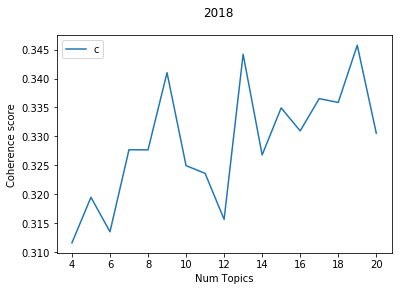

In [124]:
limit=21; start=4; step=1;
x = range(start, limit, step)
plt.figure().suptitle('2018')
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

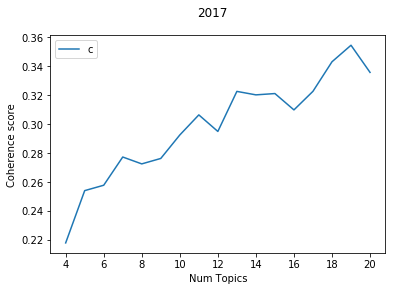

In [185]:
limit=21; start=4; step=1;
x = range(start, limit, step)
plt.figure().suptitle('2017')
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

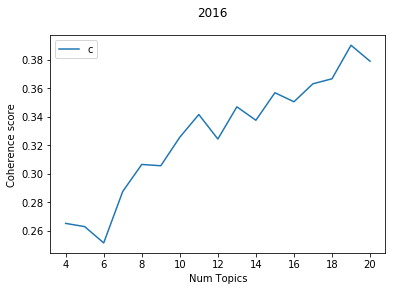

In [235]:
limit=21; start=4; step=1;
x = range(start, limit, step)
plt.figure().suptitle('2016')
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

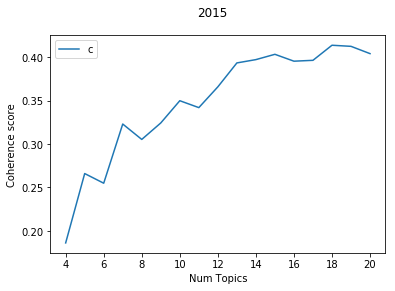

In [273]:
limit=21; start=4; step=1;
x = range(start, limit, step)
plt.figure().suptitle('2015')
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

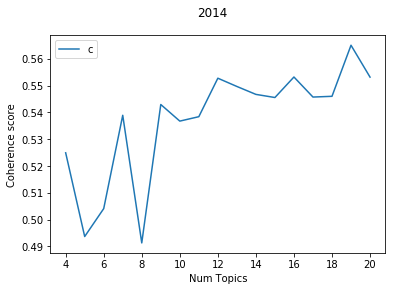

In [319]:
limit=21; start=4; step=1;
x = range(start, limit, step)
plt.figure().suptitle('2014')
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [351]:
# Select the 3 optimal models
optimal_model = model_list[9]
model_topics = optimal_model.show_topics(formatted=False)
# pprint(optimal_model.print_topics(num_words=10))

### Find the most representative document for each topic

In [352]:
# Finding the dominant topic in each Tweet


def format_topics_sentences(ldamodel, corpus=corpus, texts=data_filtered):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [353]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data_filtered)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']



In [157]:
# # Show
len(df_dominant_topic)

22384

### Compute dominant topic for each Tweet

In [354]:
# Group top 40 Tweets under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_dominant_topic.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Topic_Perc_Contrib'], ascending=[0]).head(40)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# # Format
# sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,2200,0.0,0.2000,"issue, law, order, great, work, court, news, state, program, tackle",#afl (abc) Ronnie Burns fronts court on domestic violence order: Former Geelong AFL star and Foo...
1,2061,0.0,0.1911,"issue, law, order, great, work, court, news, state, program, tackle",Ronnie Burns fronts court on domestic violence order: Former Geelong AFL star and Footy Show reg...
2,2060,0.0,0.1887,"issue, law, order, great, work, court, news, state, program, tackle",Ronnie Burns fronts court on domestic violence order: Former Geelong AFL star and Footy Show reg...
3,1791,0.0,0.1819,"issue, law, order, great, work, court, news, state, program, tackle","@Morning_Joe Your battle is not with Goddell,the battle is to change state laws on domestic viol..."
4,2196,0.0,0.1771,"issue, law, order, great, work, court, news, state, program, tackle",.@DanielleGreenMP States that the police association argues that family violence is the biggest ...


## Most dominant topics and number of documents for each:

In [355]:
# Number of Documents for Each Topic
series_topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

idx = []
topic_counts = []
keywords = []
topic_contributions = []

for (i, count) in series_topic_counts.iteritems():
    idx.append(int(i))
    keywords.append(", ".join([word for word, _ in optimal_model.show_topic(int(i))]))
    topic_counts.append(count)
    topic_contributions.append(str(round(100*count/series_topic_counts.sum(), 2))+'%')
    
df_dominant_topics = pd.DataFrame.from_dict({
    'Dominant_Topic_Num': idx,
    'Topic_Keywords': keywords, 
    'Num_Documents': topic_counts, 
    'Perc_Documents': topic_contributions
})

# Show
pd.options.display.max_colwidth = 100
df_dominant_topics.set_index('Dominant_Topic_Num', inplace=True)
df_dominant_topics

,Topic_Keywords,Num_Documents,Perc_Documents
Dominant_Topic_Num,,,
0,"issue, law, order, great, work, court, news, state, program, tackle",330,9.7%
2,"woman, justify, headlock_sometimes, senator, shelter, hit, cory_bernardi, escape, minister, voice",288,8.47%
3,"#auspol, #domesticviolence, #vaw, campaign, address, terrorism, launch, refuge, male, #whiteribbon",278,8.17%
6,"royal_commission, government, #9news, year, rosie_batty, #springst, victorian, announce, plan, p...",274,8.05%
5,"men, stop, au, change, stand, national, article, read, fight, fail",272,8.0%
1,"call, report, #dv, pm, join, mother, action, #today9, medium, #whiteribbonday",271,7.97%
4,"child, abuse, #qanda, problem, watch, video, qld, assault, protect, forum",271,7.97%
7,"song, good, story, #sbseurovision, tonight, victim, walk, end, important, prevent",257,7.55%
8,"murder, kill, death, man, year, home, #whiteribbonday, hear, every_week, shock",247,7.26%


# DF to Excel

In [356]:
from pandas import ExcelWriter

writer = ExcelWriter('output/2014/data/2014_13_clusters.xlsx')
new_df = df_dominant_topics.copy()
new_df.index += 1
new_df.to_excel(writer,'topic_rank')

for topic_no in range(13):
    new_df = sent_topics_sorteddf_mallet.iloc[topic_no*40:((topic_no+1)*40),[0,4]]
    new_df.set_index('Document_No', inplace=True)
    
    replied_texts = []
    for i, row in new_df.iterrows():
        if replied_ids[indices[i]]:
            try:
                text = api.get_status(replied_ids[indices[i]], tweet_mode='extended').full_text
                replied_texts.append(text)
            except:
                replied_texts.append('')
        else:
            replied_texts.append('')
            
    new_df['In_Reply_To'] = replied_texts
    
    new_df.reset_index(inplace=True)
    new_df.drop(['Document_No'], axis=1, inplace=True)
    new_df.to_excel(writer,'topic_'+str(topic_no+1))
    
writer.save()

# Evaluation

In [357]:
pyLDAvis.enable_notebook()
model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(model_list[9])
vis = pyLDAvis.gensim.prepare(model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
11     0.188529  0.101546       1        1  7.727426
2      0.002516 -0.280438       2        1  7.718795
8      0.011761 -0.039265       3        1  7.710075
0     -0.178876 -0.018448       4        1  7.706070
1      0.180048 -0.116903       5        1  7.706009
10    -0.277351  0.078769       6        1  7.701857
3      0.142703 -0.008825       7        1  7.694910
5      0.119295  0.196471       8        1  7.690500
6     -0.031044  0.119844       9        1  7.689399
4     -0.003347 -0.028705      10        1  7.671730
7     -0.189611  0.106754      11        1  7.670529
12    -0.052443 -0.235528      12        1  7.668184
9      0.087821  0.124728      13        1  7.644514, topic_info=     Category        Freq               Term       Total  loglift  logprob
term                                                                      
9     Default  626.000000              woman  626.000000  30.0000  30.0000
7     Default  306.000000             victim  306.000000  29.0000  29.0000
487   Default  153.000000              child  153.000000  28.0000  28.0000
29    Default  147.000000                men  147.000000  27.0000  27.0000
294   Default  142.000000             police  142.000000  26.0000  26.0000
205   Default  145.000000            support  145.000000  25.0000  25.0000
236   Default  118.000000              abuse  118.000000  24.0000  24.0000
111   Default  117.000000            service  117.000000  23.0000  23.0000
119   Default  115.000000            #auspol  115.000000  22.0000  22.0000
43    Default  116.000000               stop  116.000000  21.0000  21.0000
260   Default  113.000000               call  113.000000  20.0000  20.0000
39    Default  123.000000              issue  123.000000  19.0000  19.0000
172   Default  110.000000                law  110.000000  18.0000  18.0000
1143  Default   96.000000             #qanda   96.000000  17.0000  17.0000
441   Default   88.000000             murder   88.000000  16.0000  16.0000
512   Default   84.000000          community   84.000000  15.0000  15.0000
53    Default   84.000000              speak   84.000000  14.0000  14.0000
707   Default   78.000000              order   78.000000  13.0000  13.0000
245   Default   76.000000                 au   76.000000  12.0000  12.0000
210   Default   89.000000  #domesticviolence   89.000000  11.0000  11.0000
662   Default   74.000000             change   74.000000  10.0000  10.0000
134   Default   71.000000              great   71.000000   9.0000   9.0000
159   Default  106.000000             report  106.000000   8.0000   8.0000
622   Default   70.000000              stand   70.000000   7.0000   7.0000
3     Default   68.000000               kill   68.000000   6.0000   6.0000
601   Default   67.000000   royal_commission   67.000000   5.0000   5.0000
62    Default   83.000000             people   83.000000   4.0000   4.0000
3345  Default   67.000000                nfl   67.000000   3.0000   3.0000
353   Default   66.000000               song   66.000000   2.0000   2.0000
284   Default   66.000000           campaign   66.000000   1.0000   1.0000
...       ...         ...                ...         ...      ...      ...
1413  Topic13   15.330082                boy   15.330082   2.5712  -4.8252
218   Topic13   14.150845            hotline   14.150845   2.5712  -4.9053
492   Topic13   14.150845           homicide   14.150845   2.5712  -4.9053
676   Topic13   12.971608                 st   12.971608   2.5712  -4.9923
2716  Topic13   12.971608      brutal_murder   12.971608   2.5712  -4.9923
76    Topic13   12.971608             accept   12.971608   2.5712  -4.9923
2286  Topic13   12.971608           mcdonald   12.971608   2.5712  -4.9923
765   Topic13   11.792371                ray   11.792371   2.5712  -5.0876
2248  Topic13   10.613134             couple   10.613134   2.5712  -5.1930
3247  Topic1

In [358]:
pyLDAvis.save_html(vis, 'output/2014/visually_aided_clusters/2014_13_clusters.html')

In [113]:
import tweepy

consumer_key = 'bhnwy7L8zKWwZGsljOeJDSnPf'
consumer_secret = 'nPyTwiGZxdgMs3SUjEcfY72u7j9BsB8c9JjGgl2yZTAsHYBDiL'
access_token = '835404171335479296-bftKo65lqhjA2UwIV9jRCZGxkwOMy6a'
access_token_secret = 'wbXNX0N3O0SyFqx4MvJFHiYbunfUcV6ZamqN8jFcr6XAy'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth)